# Scopus Keyword Co-occurrence Networks Analysis

This notebook performs a detailed analysis on different keyword co-occurrence networks that can be created with automatic keywords extracted from Scopus articles using different data preprocessing approaches.

In [134]:
import pandas as pd
import numpy as np
import networkx as nx
import xml.etree.ElementTree as ET
import itertools
from matplotlib import pyplot as plt
from itertools import combinations
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib
import re
import operator

The processed articles are in XML format, with an ID element and multiple keyword elements. The keyword elements each contain a local relevance score and the keyword itself.

The data is in different files based on the length of keywords. File 'abstracts_1-1_complete.xml' contains 1-1 keywords, file 'abstracts_1-2_complete.xml' contains 1-2 keywords, etc.

In [2]:
tree2_2 = ET.parse('abstracts_2-2_complete.xml')
root2_2 = tree2_2.getroot()

tree2_3 = ET.parse('abstracts_2-3_complete.xml')
root2_3 = tree2_3.getroot()

tree1_1 = ET.parse('abstracts_1-1_complete.xml')
root1_1 = tree1_1.getroot()

tree1_2 = ET.parse('abstracts_1-2_complete.xml')
root1_2 = tree1_2.getroot()

tree1_3 = ET.parse('abstracts_1-3_complete.xml')
root1_3 = tree1_3.getroot()

tree3_3 = ET.parse('abstracts_3-3_complete.xml')
root3_3 = tree3_3.getroot()

This function creates the word co-occurrence network based on a given set of articles and their keywords. Keywords can be removed if they occur in a list of user-defined noisy keywords.

In [4]:
def collect_keyword_counts(root):
    keyword_count = dict()
    
    # looping through the tweets
    for abstract in root:
        keywords = []
        
        # id and sentiment are elements 0 and 1, hence tweets start at element 2
        # each element has the relevance score and the keyword itself, separated by ','
        for keyword_score_pair in abstract[2:]:
            score = float(keyword_score_pair.text[1:keyword_score_pair.text.find(',')])
            keyword = keyword_score_pair.text[keyword_score_pair.text.find(',')+3:keyword_score_pair.text.rfind(')')-1]
            
            # counts of keywords are tracked
            if keyword not in keywords:
                keywords.append(keyword)
                if keyword in keyword_count:
                    keyword_count[keyword] += 1
                else:
                    keyword_count[keyword] = 1
                        
    return keyword_count
    
def extract_info(root, keyword_counts, allowed_keywords):
    updated_keyword_counts = keyword_counts
    keyword_pairs_counts = dict()
    keyword_scores = dict()
    
    for abstract in root:
        keywords = []
        
        # id and sentiment are elements 0 and 1, hence tweets start at element 2
        # each element has the relevance score and the keyword itself, separated by ','
        for keyword_score_pair in abstract[2:]:
            score = float(keyword_score_pair.text[1:keyword_score_pair.text.find(',')])
            keyword = keyword_score_pair.text[keyword_score_pair.text.find(',')+3:keyword_score_pair.text.rfind(')')-1]
            
            if (keyword not in keywords) and (keyword in allowed_keywords):
                keywords.append(keyword)
                keyword_scores[keyword] = score
    
        # if a keyword in a tweet is a subset of another keyword in the tweet, only the longer keyword is kept
        exclude_keywords = []
        for keyword_pair in list(combinations(keywords, 2)):
            if keyword_pair[0] in keyword_pair[1]:
                exclude_keywords.append(keyword_pair[0])
            elif keyword_pair[1] in keyword_pair[0]:
                exclude_keywords.append(keyword_pair[1])

        for keyword in exclude_keywords:
            if keyword in keywords:
                keywords.remove(keyword)
                updated_keyword_counts[keyword] -= 1
        
        # counts are tracked for how often keywords occur together
        for keyword_pair in list(combinations(keywords, 2)):
            if frozenset(keyword_pair) in keyword_pairs_counts:
                keyword_pairs_counts[frozenset(keyword_pair)] += 1
            else:
                keyword_pairs_counts[frozenset(keyword_pair)] = 1
                
    return updated_keyword_counts, keyword_pairs_counts, keyword_scores

def create_graph(keyword_counts, keyword_pairs_counts, keyword_scores, score_threshold = None, noisy_keywords = None):
    G = nx.Graph()
    G.add_nodes_from(list(keyword_counts.keys()))
    nx.set_node_attributes(G, keyword_counts, name="count")

    for edge_to_add in keyword_pairs_counts:
        nodes = list(edge_to_add)
        G.add_edge(nodes[0], nodes[1], weight = keyword_pairs_counts[edge_to_add])
        
    # keywords that only occur once and score below a given score threshold are removed
    if score_threshold:
        remove_score = [node for node,score in keyword_scores.items() if score < score_threshold]
        remove = list(set(remove_score))
        G.remove_nodes_from(remove)
    
    # all keywords defined as noisy are removed
    if noisy_keywords:
        G.remove_nodes_from(noisy_keywords)
        
    return(G)

def full_graph_pipeline(root, count_threshold, score_threshold = None, noisy_keywords = None):
    keyword_count = collect_keyword_counts(root)
    
    updated_keyword_count = {k: v for k, v in keyword_count.items() if v > 5}
    allowed_keywords = list(updated_keyword_count.keys())
    updated_keyword_counts, keyword_pairs_counts, keyword_scores = extract_info(root, updated_keyword_count, allowed_keywords)
    
    if noisy_keywords:
        final_graph = create_graph(updated_keyword_counts, keyword_pairs_counts, keyword_scores, noisy_keywords = noisy_keywords)
        
    else:
        final_graph = create_graph(updated_keyword_counts, keyword_pairs_counts, keyword_scores)

    return final_graph

A set of copyright related 'noisy' keywords is defined.

In [ ]:
all_roots = [root1_1, root1_2, root1_3, root2_2, root2_3, root3_3]

all_keywords = set()
for root in all_roots:
    keywords = set(collect_keyword_counts(root).keys())
    all_keywords = all_keywords | keywords
    
copyright_keywords = [x for x in all_keywords if '©' in x] + [x for x in all_keywords if 'copyright' in x]
copyright_keywords.append('rights reserved')

All graphs are created for various length keywords (removing copyright keywords along the way).

In [ ]:
all_roots = {'1_1': root1_1, '1_2': root1_2, '1_3': root1_3, '2_2': root2_2, '2_3': root2_3, '3_3': root3_3}

all_graphs = dict()
for root_num in all_roots:
    created_graph = full_graph_pipeline(all_roots[root_num], 5, noisy_keywords = copyright_keywords)
    all_graphs[root_num] = created_graph

## Global Network Properties

We can create a properties table to see an overview of all graph statistics.

In [8]:
def generate_network_prop_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'nodes', 'edges', 'edge_weight', 'components'])
    for setup in graphs:
        graph = graphs[setup]
        num_nodes = len(graph.nodes())
        num_edges = len(graph.edges())
        edge_weight = graph.size(weight='weight')
        component_sizes = [len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'nodes': [num_nodes], 'edges': [num_edges]
                                            ,'edge_weight': [edge_weight], 'components': [component_sizes]})], ignore_index = True)
        
    return network_prop_df

In [9]:
generate_network_prop_table(all_graphs)

#### Centrality Distributions

We plot the degree centrality and node strength distributions for positive, negative, neutral, and all graphs with different score relevance thresholds applied.

In [91]:
def plot_graph_fun(graphs, fun, axis, offset, labels, sentiment, fun_arg = None):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        nx_fun = getattr(nx, fun)
        
        if fun_arg:
            fun_vals = sorted(list(nx_fun(graph, fun_arg).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        else:
            fun_vals = sorted(list(nx_fun(graph).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))

plot_graph_fun(all_graphs, 'degree_centrality', axes, 1, ['1-1 gram','1-2 gram', '1-3 gram','2-2 gram','2-3 gram','3-3 gram'], 'All')

axes.legend(loc='upper right')

fig.supxlabel('Degree Centrality')
fig.supylabel('Cumulative Probability')

fig.suptitle('Degree centrality distribution')
fig.tight_layout()

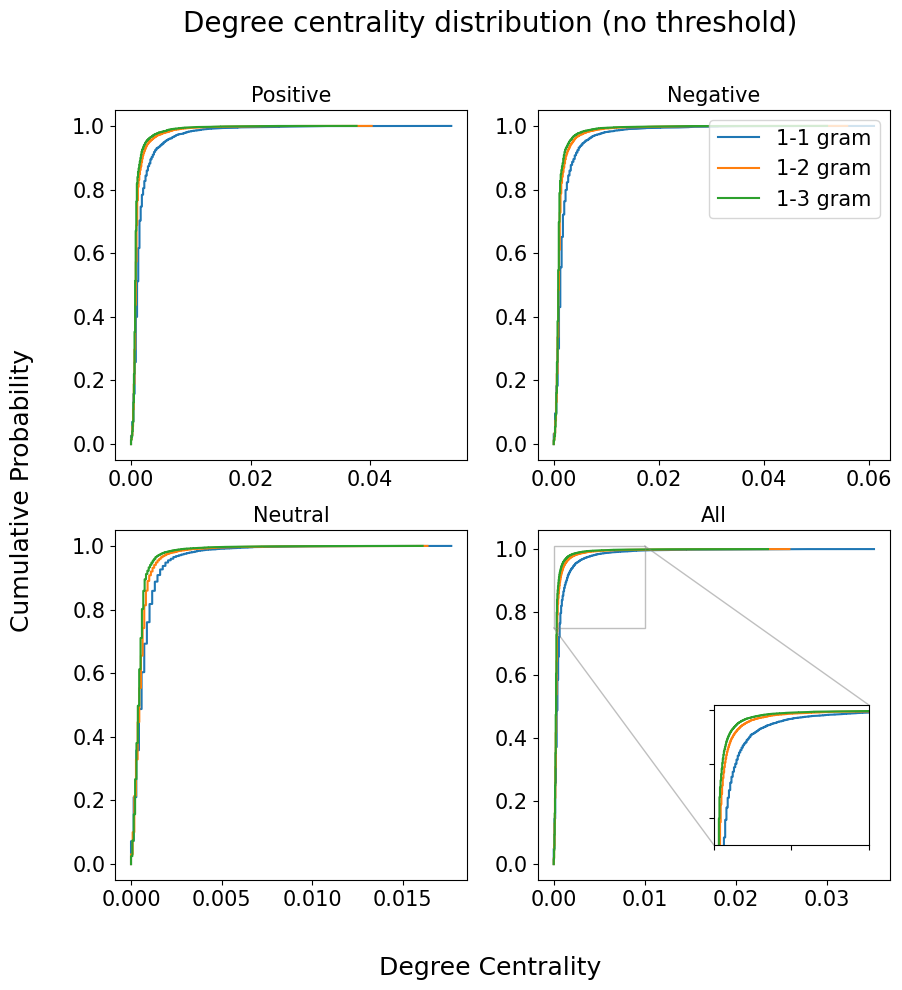

In [161]:
def plot_graph_strength(graphs, axis, offset, labels, sentiment):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        fun_vals = sorted(list(dict(nx.degree(graph, weight = 'weight')).values()))[:-offset]
        cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
        
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))

plot_graph_strength(all_graphs, axes, 1, ['1-1 gram','1-2 gram', '1-3 gram','2-2 gram','2-3 gram','3-3 gram'], 'All')

axes.legend(loc='upper right')

fig.supxlabel('Node Strength')
fig.supylabel('Cumulative Probability')

fig.suptitle('Node strength distribution')
fig.tight_layout()

#### Node Assortivity

We can also calculate network assortivity values, to see how nodes tend to connect to each other based on their strength, degree, or count.

In [26]:
def generate_network_assort_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'strength', 'degree', 'count'])
    for setup in graphs:
        graph = graphs[setup]
        strength = nx.degree_assortativity_coefficient(graph, weight = 'weight')
        degree_coeff = nx.degree_assortativity_coefficient(graph)
        count_coeff = nx.attribute_assortativity_coefficient(graph, 'count')
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'strength': [strength], 'degree': [degree_coeff]
                                            ,'count': [count_coeff]})], ignore_index = True)
        
    return network_prop_df

## Node ranking

For each graph, we can rank nodes based on their degree or node centralities.

In [28]:
# the function ranks nodes in multiple graphs at once
# since graphs can have different numbers of nodes, we can limit how many of the top nodes are retained
def sorted_cent(graphs, topN):
    degCent_df = pd.DataFrame()
    nodeStr_df = pd.DataFrame()
    
    for setup in graphs:
        
        graph = graphs[setup]

        degCent = nx.degree_centrality(graph)
        degCent_sorted=dict(sorted(degCent.items(), key=lambda item: item[1],reverse=True))
        
        degCent_df[setup] = list(degCent_sorted.keys())[0:topN]
        
        nodeStr = nx.degree(graph, weight = 'weight')
        nodeStr_sorted = dict(sorted(dict(nodeStr).items(), key=lambda item: item[1],reverse=True))
        
        nodeStr_df[setup] = list(nodeStr_sorted.keys())[0:topN]
        
    return degCent_df, nodeStr_df

In [30]:
degCent_rank_df, nodeStr_rank_df = sorted_cent(all_graphs, 1000)

Rank-based overlap (RBO) shows how similar two ranked lists are. The p value dictates how much weight is given to comparisons of higher ranked nodes. The weightage calculator calculates what percentage of the score comes from the first d elements in the lists. (https://towardsdatascience.com/how-to-objectively-compare-two-ranked-lists-in-python-b3d74e236f6a)

In [31]:
def rbo(S,T, p= 0.9):
    """ Takes two lists S and T of any lengths and gives out the RBO Score
    Parameters
    ----------
    S, T : Lists (str, integers)
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1. Default 0.9 give the top 10 
        elements 86% of the contribution in the final score.
    
    Returns
    -------
    Float of RBO score
    """
    
    # Fixed Terms
    k = max(len(S), len(T))
    x_k = len(set(S).intersection(set(T)))
    
    summation_term = 0

    # Loop for summation
    # k+1 for the loop to reach the last element (at k) in the bigger list    
    for d in range (1, k+1): 
            # Create sets from the lists
            set1 = set(S[:d]) if d < len(S) else set(S)
            set2 = set(T[:d]) if d < len(T) else set(T)
            
            # Intersection at depth d
            x_d = len(set1.intersection(set2))

            # Agreement at depth d
            a_d = x_d/d   
            
            # Summation
            summation_term = summation_term + math.pow(p, d) * a_d

    # Rank Biased Overlap - extrapolated
    rbo_ext = (x_k/k) * math.pow(p, k) + ((1-p)/p * summation_term)

    return rbo_ext

def weightage_calculator(p,d):
    """ Takes values of p and d
    ----------
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1.
    d : depth at which the weight has to be calculated
    
    Returns
    -------
    Float of Weightage Wrbo at depth d
    """

    summation_term = 0

    for i in range (1, d): # taking d here will loop upto the value d-1 
        summation_term = summation_term + math.pow(p,i)/i


    Wrbo_1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - summation_term))

    return Wrbo_1_d

For a p value of 0.9, the top 13 nodes count for ~90% of the score; for a 0.99 p value, the top 130 count for ~90% of the score.

In [32]:
print(weightage_calculator(0.9, 13))
print(weightage_calculator(0.99, 130))

0.9079099164989892
0.9039562429806366


We calculate rank based overlap of all networks. We calculate these values for p values of 0.9 and 0.99. 

#### Node Strength Rankings

The shortlist ranking uses a p-value of 0.9 (meaning a smaller proportion of the rankings count towards the similarity score), while the longlist ranking uses a p-value of 0.99 (meaning a greater proportion of the rankings count towards the score).

In [ ]:
nodeStr_shortlist_all_df = pd.DataFrame(columns = nodeStr_rank_df.columns, index = nodeStr_rank_df.columns)

for col1 in nodeStr_rank_df:
    for col2 in nodeStr_rank_df:
        nodeStr_shortlist_all_df[col1][col2] = rbo(nodeStr_rank_df[col1],nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_all_df = nodeStr_shortlist_all_df.astype(float)

nodeStr_longlist_all_df = pd.DataFrame(columns = nodeStr_rank_df.columns, index = nodeStr_rank_df.columns)

for col1 in nodeStr_rank_df:
    for col2 in nodeStr_rank_df:
        nodeStr_longlist_all_df[col1][col2] = rbo(nodeStr_rank_df[col1],nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_all_df = nodeStr_longlist_all_df.astype(float)

In [ ]:
nodeStr_shortlist_all_df.round(3)

In [ ]:
nodeStr_longlist_all_df

#### Degree Centrality Rankings

In [ ]:
degCent_shortlist_all_df = pd.DataFrame(columns = degCent_rank_df.columns, index = degCent_rank_df.columns)

for col1 in degCent_rank_df:
    for col2 in degCent_rank_df:
        degCent_shortlist_all_df[col1][col2] = rbo(degCent_rank_df[col1],degCent_rank_df[col2], p = 0.9)
        
degCent_shortlist_all_df = degCent_shortlist_all_df.astype(float)

degCent_longlist_all_df = pd.DataFrame(columns = degCent_rank_df.columns, index = degCent_rank_df.columns)

for col1 in degCent_rank_df:
    for col2 in degCent_rank_df:
        degCent_longlist_all_df[col1][col2] = rbo(degCent_rank_df[col1],degCent_rank_df[col2], p = 0.99)
        
degCent_longlist_all_df = degCent_longlist_all_df.astype(float)

In [ ]:
degCent_shortlist_all_df.round(3)

In [ ]:
degCent_longlist_all_df.round(3)

## Community Structure

In [ ]:
communities = dict()

for graph in all_graphs:
    communities[graph] = nx.community.louvain_communities(all_graphs[graph], weight = 'weight', seed = 0)
    
graph_communities = dict()

for graph in all_graphs:
    nodeStr = nx.degree(all_graphs[graph], weight = 'weight')
    nodeStr_sorted = dict(sorted(dict(nodeStr).items(), key=lambda item: item[1],reverse=True))
    
    working_communities = communities[graph]
    i = 0
    for community in working_communities:
        if len(community) > 10:
            community_values = {x:nodeStr_sorted[x] for x in community}
            top_10_nodes = list(dict(sorted(community_values.items(), key=lambda x: x[1], reverse=True)[:10]).keys())
            
            graph_communities[graph + '_com_num_' + str(i)] = {'length': len(community), 'top_nodes': top_10_nodes}
            i += 1

In [ ]:
[graph_communities[x] for x in graph_communities if '3_3' in x]